In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as anneu


In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'lab_name="churchlandlab"' & 'subject_project = "churchland_learninglifespan"'

########### WEIGHINGS ########### 
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date > "2020-02-22"'
#baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2020-02-25"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
#avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
#bb = subj * avg_baseline_weight_date
weight_df = pd.DataFrame(b.fetch(as_dict=True))
#baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
weight_df.tail(n=5)

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,lab_name,subjectlab_ts,subjectproject_ts,avg_weight
184,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-02,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,churchlandlab,2020-03-05 09:42:01,2020-03-05 09:41:49,33.160000
185,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-03,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,churchlandlab,2020-03-05 09:42:01,2020-03-05 09:41:49,30.459999
186,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-04,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,churchlandlab,2020-03-05 09:42:01,2020-03-05 09:41:49,29.420000
187,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-02-24,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,churchlandlab,2020-03-05 09:42:01,2020-03-05 09:41:49,33.639999
188,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-02-25,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,churchlandlab,2020-03-05 09:42:01,2020-03-05 09:41:49,33.009998


In [3]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

normalized_df = weight_df.copy()
# day 0 is the start of the experiment
normalized_df['session_day'] = (normalized_df['session_date'] - (datetime(2020, 3, 2)).date()).dt.days

normalized2 = pd.DataFrame([])
for index, sjdat in normalized_df.groupby(['subject_uuid']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat.loc[sjdat.session_day < 1, 'avg_weight'].mean()
    normalized2 = normalized2.append(sjdat)

########### CONDITIONS ########### 
CA = 'Citric Acid'
condition_map = {'CSHL061':CA, 'CSHL062':CA, 'CSHL063':CA, 'CSHL064':CA, 
'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
'CSHL070':CA, 'CSHL071':CA, 'CSHL072':CA, 'CSHL073':CA, 
'CSHL074':CA, 'CSHL075':CA}
normalized2['condition'] = normalized2.subject_nickname.map(condition_map)

# choose only these animals
normalized2 = normalized2.loc[normalized2.subject_nickname.isin(condition_map.keys()), :]
sorted(normalized2.subject_nickname.unique())

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


['CSHL061',
 'CSHL062',
 'CSHL063',
 'CSHL064',
 'CSHL065',
 'CSHL066',
 'CSHL067',
 'CSHL068',
 'CSHL069',
 'CSHL070',
 'CSHL071',
 'CSHL072',
 'CSHL073',
 'CSHL074',
 'CSHL075']

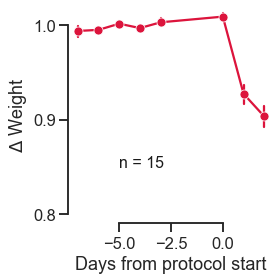

In [11]:
palette = sns.xkcd_palette(['raspberry'])
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
    
sns.lineplot(x="session_day", y="avg_weight", color="crimson",
             estimator=np.mean, err_style='bars', marker='o',
             ci=68, data=normalized2, ax=ax, legend=False)
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("$\Delta$ Weight")     
ax.set(ylim=[0.79, 1.02], yticks=[0.8, 0.9, 1])
ax.text(-5, 0.85, 'n = 15', {'color':'k', 'fontsize':16})

f.tight_layout()
sns.despine(trim=True)

f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
